In [ ]:
from osgeo import gdal
import os
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pyperclip import copy
import re
from datetime import datetime
import matplotlib.pyplot as plt

# 定义函数以获取特定类型的文件

In [2]:
# def get_file_of_type(path, extensions):
#     files = []
#     for file in os.listdir(path):
#         for extension in extensions:
#             if file.endswith(extension):
#                 files.append(os.path.join(path, file))
#     return files

In [3]:
# path = r"W:\20221012 佤酒庄设计项目\08-现场照片\20230804 现场考察哦照片\Photos"
# extentions= [".jpg", ".JPG", ".png", ".PNG", ".jpeg", ".JPEG"]
# len(get_file_of_type(path, extentions))
# get_file_of_type(path, extentions)

#定义函数以读取每个文件的exif信息

In [2]:
def get_gps_metadata_from_image(image_path):
    """Reads the EXIF data from an image file using GDAL.

    Args:
        image_path (str): The path to the image file.

    Returns:
        dict: A dictionary of EXIF data.
    """
    # Open the image file
    image = gdal.Open(image_path)

    # Get the image metadata
    metadata = image.GetMetadata()
    # if not metadata:
    #     raise ValueError("No EXIF metadata found")

    # Get the image EXIF tags
    gps_metadata = {key:metadata[key] for key in metadata.keys()}
    
    return gps_metadata


In [3]:
def get_decimal_from_dms(dms, ref):
    dms = re.findall(r'\d+\.?\d*', dms)
    dms = [float(num) for num in dms]
    degrees = dms[0]
    minutes = dms[1] / 60.0
    seconds = dms[2] / 3600.0

    if ref in ['S', 'W']:
        degrees = -degrees
        minutes = -minutes
        seconds = -seconds

    return round(degrees + minutes + seconds, 5)

In [4]:
def get_coordinates(geotags):
    lat = get_decimal_from_dms(geotags['EXIF_GPSLatitude'], geotags['EXIF_GPSLatitudeRef'])
    lon = get_decimal_from_dms(geotags['EXIF_GPSLongitude'], geotags['EXIF_GPSLongitudeRef'])
    alt = extract_number(geotags['EXIF_GPSAltitude'])

    return (lon,lat,alt)

In [5]:
def extract_number(s):
    if isinstance(s, str):
        numbers = re.findall(r"[-+]?\d*\.\d+|\d+", s)
        return float(numbers[0]) if numbers else None
    else:
        return s

In [31]:
folder_path = r"W:\城建院数据\20220526 西藏项目\08-现场照片\20230808\滨河_20230808"
files = os.listdir(folder_path)
data = []
for file in files:
    try:
        if file.endswith(('.jpg', '.JPG')):  # add file types if needed.
            img_path = os.path.join(folder_path, file)
            geotagging = get_gps_metadata_from_image(img_path)
            coordinates = get_coordinates(geotagging)
            datetime = datetime.strptime(geotagging['EXIF_DateTime'],'%Y:%m:%d %H:%M:%S')
            data.append([file,img_path,geotagging])
    except:
        continue

In [32]:
df = pd.DataFrame(data)
df = pd.DataFrame(data, columns=['Name', 'Path','EXIF'])
exif_df = pd.json_normalize(df['EXIF'])
df = pd.concat([df, exif_df], axis=1)
gdf = gpd.GeoDataFrame(df, geometry=df.apply(get_coordinates, axis=1).apply(Point))

In [33]:
columns_to_select = ['Name','Path','EXIF_DateTime','EXIF_FocalLengthIn35mmFilm',
       'EXIF_GPSImgDirection','EXIF_GPSImgDirectionRef','EXIF_Make',
       'EXIF_PixelXDimension', 'EXIF_PixelYDimension',
       'EXIF_SubjectArea','EXIF_XResolution', 'EXIF_YResolution',      
       'EXIF_GPSDOP','EXIF_SubjectDistance', 'EXIF_SubjectDistanceRange','geometry']

In [34]:
for col in columns_to_select:
    # If the column does not exist in the DataFrame
    if col not in gdf.columns:
        # Add the column to the DataFrame with 'None' as the default value
        gdf[col] = None

# Now select your columns
gdf = gdf[columns_to_select]

In [35]:
gdf['EXIF_GPSImgDirection'] = gdf['EXIF_GPSImgDirection'].apply(extract_number)
gdf['EXIF_XResolution'] = gdf['EXIF_XResolution'].apply(extract_number)
gdf['EXIF_YResolution'] = gdf['EXIF_YResolution'].apply(extract_number)
gdf['EXIF_GPSDOP'] = gdf['EXIF_GPSDOP'].apply(extract_number)
gdf['Pano'] = 1 if gdf['EXIF_Make'].str.contains('RICOH').any() else 0
gdf['Type'] = '现状'
gdf['Description'] = None

In [36]:
gdf.to_file(os.path.join(folder_path,f'{os.path.basename(folder_path)}.json'),driver="GeoJSON")

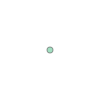

In [150]:
Point(df.apply(get_coordinates, axis=1)[1])

In [151]:
df['coords'] = df.apply(get_coordinates, axis=1).apply(Point)

In [204]:
gdf

,Name,EXIF_ApertureValue,EXIF_BrightnessValue,EXIF_ColorSpace,EXIF_DateTime,EXIF_DateTimeDigitized,EXIF_DateTimeOriginal,EXIF_ExifVersion,EXIF_ExposureBiasValue,EXIF_ExposureMode,...,EXIF_Interoperability_Version,EXIF_MaxApertureValue,EXIF_Saturation,EXIF_SceneCaptureType,EXIF_Sharpness,EXIF_SubjectDistance,EXIF_SubjectDistanceRange,EXIF_SubSecTime,EXIF_YCbCrPositioning,geometry
0,IMG_4751.JPG,(1.69599),(5.27445),65535,2023:08:04 08:36:08,2023:08:04 08:36:08,2023:08:04 08:36:08,0232,(0),0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (23.186 99.273)
1,IMG_4752.JPG,(1.69599),(6.61719),65535,2023:08:04 08:36:12,2023:08:04 08:36:12,2023:08:04 08:36:12,0232,(0),0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (23.186 99.273)
2,IMG_4753.JPG,(1.69599),(6.58655),65535,2023:08:04 08:36:19,2023:08:04 08:36:19,2023:08:04 08:36:19,0232,(0),0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (23.186 99.273)
3,IMG_4754.JPG,(1.69599),(6.08681),65535,2023:08:04 08:36:24,2023:08:04 08:36:24,2023:08:04 08:36:24,0232,(0),0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (23.186 99.273)
4,IMG_4755.JPG,(1.69599),(8.07727),65535,2023:08:04 08:36:41,2023:08:04 08:36:41,2023:08:04 08:36:41,0232,(0),0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (23.186 99.273)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,PXL_20230805_033743460.jpg,(2.28),(0.33),1,2023:08:05 11:37:43,2023:08:05 11:37:43,2023:08:05 11:37:43,0232,(0),0,...,0x30 0x31 0x30 0x30,(2.28),0,0,0,(4.29497e+09),3,460,1,POINT (23.187 99.279)
314,PXL_20230805_034249985.jpg,(1.78),(1.39),1,2023:08:05 11:42:49,2023:08:05 11:42:49,2023:08:05 11:42:49,0232,(0),0,...,0x30 0x31 0x30 0x30,(1.78),0,0,0,(1.992),2,985,1,POINT (23.187 99.279)
315,PXL_20230805_034253285.jpg,(2.28),(1.22),1,2023:08:05 11:42:53,2023:08:05 11:42:53,2023:08:05 11:42:53,0232,(0),0,...,0x30 0x31 0x30 0x30,(2.28),0,0,0,(4.29497e+09),3,285,1,POINT (23.187 99.279)
316,PXL_20230805_034309238.MP.jpg,(2.28),(1.51),1,2023:08:05 11:43:09,2023:08:05 11:43:09,2023:08:05 11:43:09,0232,(0),0,...,0x30 0x31 0x30 0x30,(2.28),0,0,0,(4.29497e+09),3,238,1,POINT (23.187 99.279)


In [7]:
image_path = r'D:\Desktop\IMG_20230919_214804.jpg'
geotagging = get_gps_metadata_from_image(image_path)
geotagging

{'EXIF_ApertureValue': '(2)',
 'EXIF_BitsPerSample': '8 8 8',
 'EXIF_BrightnessValue': '(0)',
 'EXIF_ColorSpace': '65535',
 'EXIF_ComponentsConfiguration': '0x01 0x02 0x03 0x00',
 'EXIF_CompressedBitsPerPixel': '(0.95)',
 'EXIF_Contrast': '0',
 'EXIF_CustomRendered': '1',
 'EXIF_DateTime': '2023:09:19 21:48:04',
 'EXIF_DateTimeDigitized': '2023:09:19 21:48:04',
 'EXIF_DateTimeOriginal': '2023:09:19 21:48:04',
 'EXIF_DeviceSettingDescription': '0x69 0x70 0x70 0x00',
 'EXIF_DigitalZoomRatio': '(1)',
 'EXIF_Document_Name': '',
 'EXIF_ExifVersion': '0210',
 'EXIF_ExposureBiasValue': '(0)',
 'EXIF_ExposureMode': '0',
 'EXIF_ExposureProgram': '2',
 'EXIF_ExposureTime': '(0.01)',
 'EXIF_FileSource': '0x03',
 'EXIF_Flash': '0',
 'EXIF_FlashpixVersion': '0100',
 'EXIF_FNumber': '(2)',
 'EXIF_FocalLength': '(5.75)',
 'EXIF_FocalLengthIn35mmFilm': '27',
 'EXIF_GainControl': '0',
 'EXIF_Interoperability_Index': 'R98',
 'EXIF_Interoperability_Version': '0x30 0x31 0x30 0x30',
 'EXIF_ISOSpeedRatings'

In [233]:
image_path = r'W:\20221012 佤酒庄设计项目\08-现场照片\20230804 现场考察哦照片\Pano\R0018032.JPG'
geotagging = get_gps_metadata_from_image(image_path)
geotagging

{'EXIF_ApertureValue': '(2)',
 'EXIF_BrightnessValue': '(7.13)',
 'EXIF_ColorSpace': '1',
 'EXIF_ComponentsConfiguration': '0x01 0x02 0x03 0x00',
 'EXIF_Copyright': '',
 'EXIF_DateTime': '2023:08:04 15:10:18',
 'EXIF_DateTimeDigitized': '2023:08:04 15:10:18',
 'EXIF_DateTimeOriginal': '2023:08:04 15:10:18',
 'EXIF_ExifVersion': '0231',
 'EXIF_ExposureBiasValue': '(0)',
 'EXIF_ExposureMode': '0',
 'EXIF_ExposureProgram': '2',
 'EXIF_ExposureTime': '(0.0015625)',
 'EXIF_Flash': '32',
 'EXIF_FlashpixVersion': '0100',
 'EXIF_FNumber': '(2)',
 'EXIF_FocalLength': '(1.3)',
 'EXIF_GPSImgDirection': '(305.05)',
 'EXIF_GPSImgDirectionRef': 'M',
 'EXIF_GPSVersionID': '0x02 0x03 0x00 0x00',
 'EXIF_ImageDescription': '                                                               ',
 'EXIF_Interoperability_Index': 'R98',
 'EXIF_Interoperability_Version': '0x30 0x31 0x30 0x30',
 'EXIF_ISOSpeedRatings': '64',
 'EXIF_LightSource': '0',
 'EXIF_Make': 'RICOH',
 'EXIF_MakerNote': 'Ricoh',
 'EXIF_MaxAper

In [133]:
datetime.strptime(geotagging['EXIF_DateTime'],'%Y:%m:%d %H:%M:%S')

datetime.datetime(2023, 8, 4, 8, 36, 41)

In [115]:
geotagging['EXIF_GPSLatitude']

'(23) (11) (10.51)'

In [96]:
coordinates = get_coordinates(geotagging)
coordinates

(23.18625, 99.27346)

In [22]:
image = gdal.Open(r'W:\20221012 佤酒庄设计项目\08-现场照片\20230804 现场考察哦照片\Photos\IMG_4755.JPG')

In [187]:
gdf.columns

Index(['Name', 'EXIF_ApertureValue', 'EXIF_BrightnessValue', 'EXIF_ColorSpace',
       'EXIF_DateTime', 'EXIF_DateTimeDigitized', 'EXIF_DateTimeOriginal',
       'EXIF_ExifVersion', 'EXIF_ExposureBiasValue', 'EXIF_ExposureMode',
       'EXIF_ExposureProgram', 'EXIF_ExposureTime', 'EXIF_Flash',
       'EXIF_FNumber', 'EXIF_FocalLength', 'EXIF_FocalLengthIn35mmFilm',
       'EXIF_GPSAltitude', 'EXIF_GPSAltitudeRef', 'EXIF_GPSDateStamp',
       'EXIF_GPSDestBearing', 'EXIF_GPSDestBearingRef',
       'EXIF_GPSHPositioningError', 'EXIF_GPSImgDirection',
       'EXIF_GPSImgDirectionRef', 'EXIF_GPSLatitude', 'EXIF_GPSLatitudeRef',
       'EXIF_GPSLongitude', 'EXIF_GPSLongitudeRef', 'EXIF_GPSSpeed',
       'EXIF_GPSSpeedRef', 'EXIF_ISOSpeedRatings', 'EXIF_LensMake',
       'EXIF_LensModel', 'EXIF_LensSpecification', 'EXIF_Make',
       'EXIF_MakerNote', 'EXIF_MeteringMode', 'EXIF_Model', 'EXIF_OffsetTime',
       'EXIF_OffsetTimeDigitized', 'EXIF_OffsetTimeOriginal',
       'EXIF_Orientation',

In [23]:
if __name__ == "__main__":
    
# Use the functions
path = r"W:\20221012 佤酒庄设计项目\08-现场照片\20230804 现场考察哦照片\Photos"
geojson = create_geojson(path)
#validate_geojson(geojson)